# **Imports**


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

## **Download and Prepare the Dataset**

In [4]:
df = pd.read_csv('/content/IMDB Dataset.csv')


In [5]:
df.isna().sum()

,0
review,0
sentiment,0


In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [8]:
print(df.shape)

(50000, 2)


In [9]:
#split the data into train and test

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # Adjust test_size as needed

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (40000, 2)
Test data shape: (10000, 2)


In [10]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['review'])
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_df['review'])
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_df['review'])
test_padded = pad_sequences(test_sequences,maxlen=max_length)

# Convert sentiment labels to numerical values (e.g., 'positive' to 1, 'negative' to 0)
train_labels = np.array([1 if sentiment == 'positive' else 0 for sentiment in train_df['sentiment']])
test_labels = np.array([1 if sentiment == 'positive' else 0 for sentiment in test_df['sentiment']])

## **LSTM Model**

In [13]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [14]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model

history = model_lstm.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels), callbacks=[early_stopping])


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6633 - loss: 0.5925 - val_accuracy: 0.8585 - val_loss: 0.3327
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8684 - loss: 0.3440 - val_accuracy: 0.8540 - val_loss: 0.3480
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8908 - loss: 0.2891 - val_accuracy: 0.8578 - val_loss: 0.3303
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9081 - loss: 0.2482 - val_accuracy: 0.8619 - val_loss: 0.3336
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9208 - loss: 0.2102 - val_accuracy: 0.8545 - val_loss: 0.3334
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9350 - loss: 0.1774 - val_accuracy: 0.8457 - val_loss: 0.4485


In [15]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 120, 16)               │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (32, 64)                    │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 24)                    │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 24)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 1)                     │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 546,965 (2.09 MB)

 Trainable params: 182,321 (712.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 364,644 (1.39 MB)

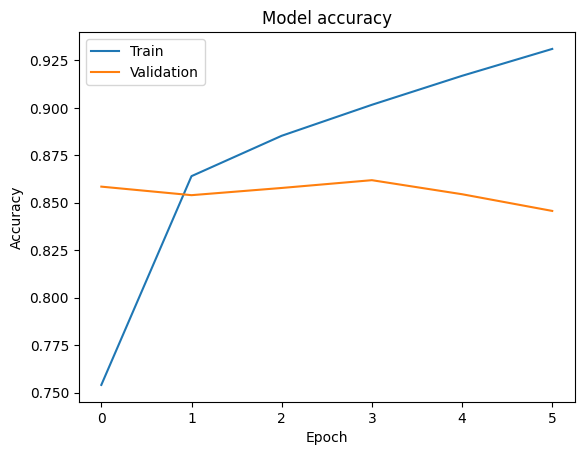

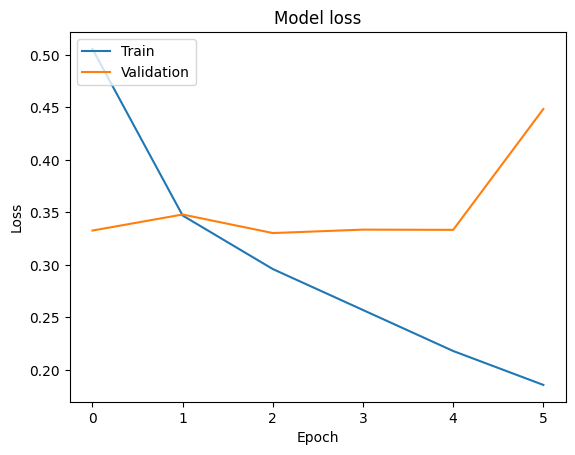

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model_lstm.predict(test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8578
Precision: 0.8940945739812596
Recall: 0.8142488589005755
F1-score: 0.8523057748234316


# **GRU** **Model**

In [18]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(64),  # Use GRU layer instead of LSTM
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_gru = model_gru.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels), callbacks=[early_stopping])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6311 - loss: 0.6122 - val_accuracy: 0.8594 - val_loss: 0.3344
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8667 - loss: 0.3436 - val_accuracy: 0.8724 - val_loss: 0.2913
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9057 - loss: 0.2606 - val_accuracy: 0.8697 - val_loss: 0.3302
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9221 - loss: 0.2169 - val_accuracy: 0.8653 - val_loss: 0.3445
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9394 - loss: 0.1802 - val_accuracy: 0.8584 - val_loss: 0.3421


In [19]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (32, 120, 16)               │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (32, 64)                    │          15,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 24)                    │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 24)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 1)                     │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 531,989 (2.03 MB)

 Trainable params: 177,329 (692.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 354,660 (1.35 MB)

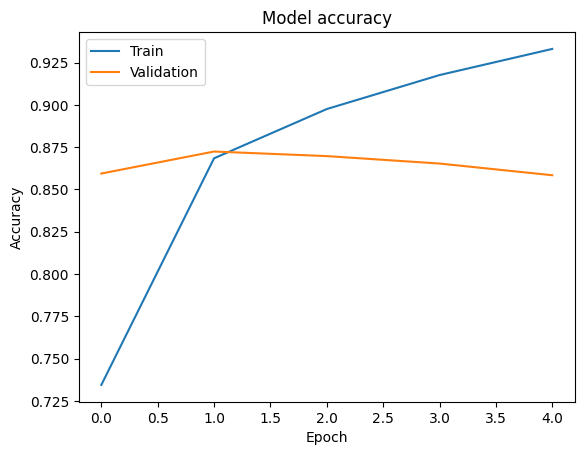

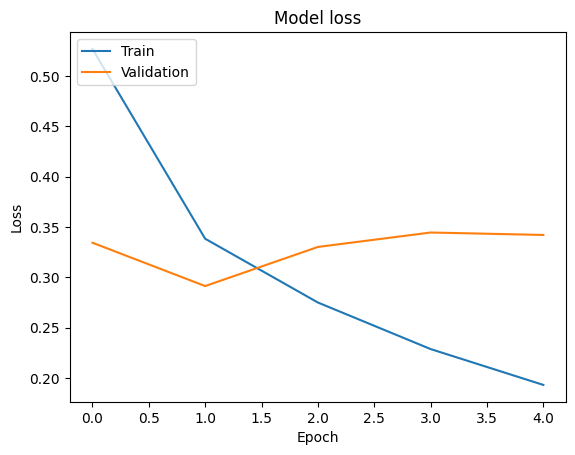

In [20]:
# Plot training & validation accuracy values
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
y_pred_prob_gru = model_gru.predict(test_padded)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

# Calculate metrics
accuracy_gru = accuracy_score(test_labels, y_pred_gru)
precision_gru = precision_score(test_labels, y_pred_gru)
recall_gru = recall_score(test_labels, y_pred_gru)
f1_gru = f1_score(test_labels, y_pred_gru)

print(f"GRU Accuracy: {accuracy_gru}")
print(f"GRU Precision: {precision_gru}")
print(f"GRU Recall: {recall_gru}")
print(f"GRU F1-score: {f1_gru}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
GRU Accuracy: 0.8724
GRU Precision: 0.8463095895453708
GRU Recall: 0.9124826354435404
GRU F1-score: 0.8781512605042017


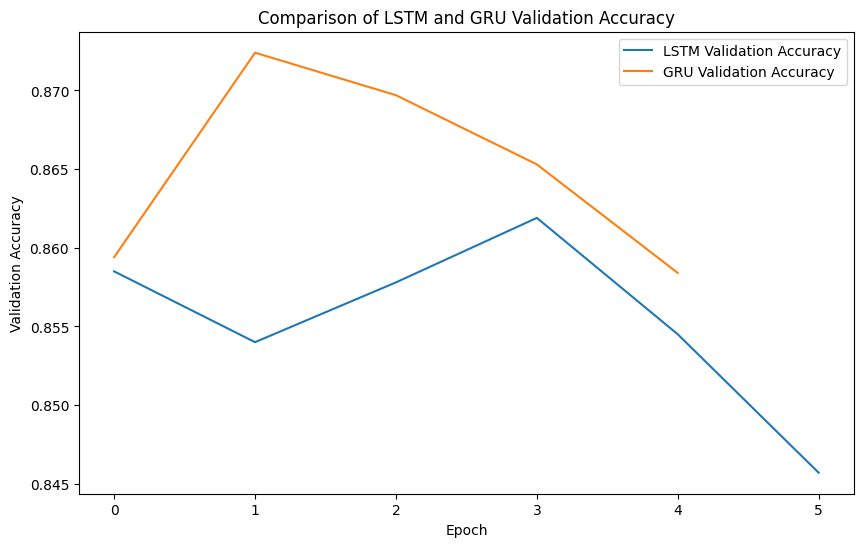

GRU Model is better with an accuracy of: 0.8724


In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='GRU Validation Accuracy')
plt.title('Comparison of LSTM and GRU Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

if accuracy > accuracy_gru:
  print("LSTM Model is better with an accuracy of:", accuracy)
else:
  print("GRU Model is better with an accuracy of:", accuracy_gru)